## 로지스틱 회귀

In [1]:
import numpy as np
import pandas
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [2]:
df = web.DataReader("SPY", data_source="yahoo", start="2016-01-01", end="2022-04-26")[["Open", "High", "Low", "Close"]]
df.dropna()

,Open,High,Low,Close
Date,,,,
2015-12-31,205.130005,205.889999,203.869995,203.869995
2016-01-04,200.490005,201.029999,198.589996,201.020004
2016-01-05,201.399994,201.899994,200.050003,201.360001
2016-01-06,198.339996,200.059998,197.600006,198.820007
2016-01-07,195.330002,197.440002,193.589996,194.050003
...,...,...,...,...
2022-04-20,446.920013,447.570007,443.480011,444.709991
2022-04-21,448.540009,450.010010,437.100006,438.059998
2022-04-22,436.910004,438.079987,425.440002,426.040009


In [3]:
df["MA10"] = df["Close"].rolling(window=10).mean()
df["Corr"] = df["Close"].rolling(window=10).corr(df["MA10"])
df["Open-Close"] = df["Open"]-df["Close"].shift(1)
df["Open-Open"] = df["Open"]-df["Open"].shift(1)
df = df.dropna()

In [4]:
X1 = df[["Open", "Close", "MA10","High", "Low", "Corr", "Open-Close", "Open-Open"]]
X2 = df[["Open", "Close", "Open-Close", "Open-Open"]]

y = np.where(df["Close"].shift(-1) > df["Close"], 1, -1)

In [5]:
train_pct = 0.8
split = int(train_pct*len(df))

X1_train, X1_test, y_train, y_test = X1[:split], X1[split:], y[:split], y[split:]
X2_train, X2_test, y_train, y_test = X2[:split], X2[split:], y[:split], y[split:]

In [6]:
model1 = LogisticRegression()
model1.fit(X1_train, y_train)

model2 = LogisticRegression()
model2.fit(X2_train, y_train)

print(pd.DataFrame(zip(X1.columns, np.transpose(model1.coef_))))  # 회귀계수

            0                         1
0        Open    [0.029821215853404595]
1       Close   [-0.028928319547045035]
2        MA10   [-0.002676778064687749]
3        High   [-0.005885916050547549]
4         Low    [0.008672834586906238]
5        Corr  [-0.0013022204753899958]
6  Open-Close    [-0.05359596975146337]
7   Open-Open    [-0.02732064319955332]


In [7]:
predicted1 = model1.predict(X1_test)
predicted2 = model2.predict(X2_test)

In [8]:
print(metrics.confusion_matrix(y_test, predicted1))

[[  8 137]
 [  6 164]]


In [9]:
print(metrics.classification_report(y_test, predicted1))
print(model1.score(X1_test, y_test))
# acc : 58%

              precision    recall  f1-score   support

          -1       0.57      0.06      0.10       145
           1       0.54      0.96      0.70       170

    accuracy                           0.55       315
   macro avg       0.56      0.51      0.40       315
weighted avg       0.56      0.55      0.42       315

0.546031746031746


In [10]:
# 매매전략

df["Signal1"] = model1.predict(X1)
df["Signal2"] = model2.predict(X2)

df["SPY_Returns"] = np.log(df["Close"] / df["Close"].shift(1))  # SNP 일간수익률
Cum_SPY_Returns = np.cumsum(df[split:]["SPY_Returns"])  # SNP 누적수익률

df["STR1_Returns"] = df["SPY_Returns"] * df["Signal1"].shift(1)
Cum_STR1_Returns = np.cumsum(df[split:]["STR1_Returns"])

df["STR2_Returns"] = df["SPY_Returns"] * df["Signal2"].shift(1)
Cum_STR2_Returns = np.cumsum(df[split:]["STR2_Returns"])

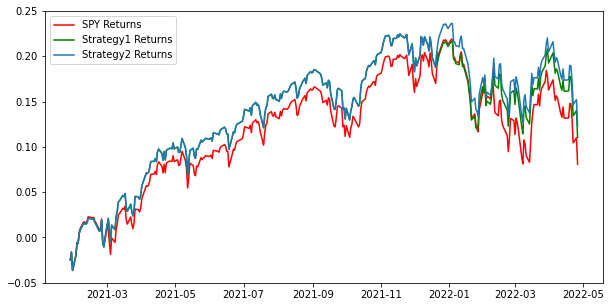

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label="SPY Returns")
plt.plot(Cum_STR1_Returns, color='g', label="Strategy1 Returns")
plt.plot(Cum_STR2_Returns, label="Strategy2 Returns")
plt.legend()
plt.show()

# "Open", "Close", "Open-Close", "Open-Open"만 사용했을때 샤프비율이 0.31로 가장 높았음

In [12]:
# 샤프비율 계산

Std1= Cum_STR1_Returns.std()
Sharpe1 = (Cum_STR1_Returns - Cum_SPY_Returns)/Std1
Sharpe1 = Sharpe1.mean()
print("Sharpe1 ratio :", Sharpe1)

Std2= Cum_STR2_Returns.std()
Sharpe2 = (Cum_STR2_Returns - Cum_SPY_Returns)/Std2
Sharpe2 = Sharpe2.mean()
print("Sharpe2 ratio :", Sharpe2)

# 샤프비율이 양수로 나타남

Sharpe1 ratio : 0.26938853985773487
Sharpe2 ratio : 0.3186671481747065
